<h1>First full pipeline test on Antarctica</h1>
<p>

*Separate notebook created by Yara to avoid overwrites. We can merge this at the end.*

First install the extra `proplot` package needed for this notebook.

In [70]:
!pip install proplot 

In [79]:
from icepyx import icesat2data as ipd
import numpy as np
import os
import shutil
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys
import pyproj
import proplot as plot

%matplotlib widget
#%matplotlib inline

## Download and extract histograms and other relevant parameters as npy arrays
**Skip to the next step if you have already saved the arrays previously.**

Extract histograms using the `get_hists.py` module. Using this script, we extract and save the relevant variables once and load them quickly instead of downloading and reading the HDF5 every time.

In [3]:
!python /home/jovyan/surface_classification/scripts/get_hists.py --HELP

Commandline options:
Type '--HELP' or '-H' flag for help.
Type '--DIR=' or '-D:' flag to specify data directory.
Type '--EXTENT=' or '-E:' flag to specify data spatial extent.
Type '--DATE=' or '-T:' to specify data date range.
Type '--USER=' or '-U:' flag to specify EarthData username.
Type '--EMAIL=' or '-E:' flag to specify EarthData email.
Type '--noDownload' or '-N' flag to skip downloading data if it's already there.
Done.


In [72]:
#spatial_extent = [31.5, -70.56, 33.73, -69.29]
spatial_extent = [0.0, -72.0, 50.00, -68.5]
date_range = ['2020-03-30','2020-04-1']

In [5]:
# We iterate the regions eastwards
#for area in range(1, 20):
#    spatial_extent[0] = spatial_extent[0]+2
#    spatial_extent[2] = spatial_extent[2]+2
#    current_extent = str(spatial_extent)[1:-1]
#    print("\nCurrent extent: " + current_extent)

user = "JordiBN"
email = "jordi.bolibar@univ-grenoble-alpes.fr"
data_dir = '/home/jovyan/data'
download = False

# I have to execute this code outside get_hists.py, otherwise I cannot insert the EarthData password from the notebook
#-- login to earth data and get data
if(download):
    region_a = ipd.Icesat2Data('ATL06', spatial_extent, date_range)
    region_a.earthdata_login(user,email)

    #-- put data order
    region_a.order_vars.append(var_list=['count'])
    #-- download data
    region_a.download_granules(data_dir)

In [6]:
process = False
if(process):
    !python /home/jovyan/surface_classification/scripts/get_hists.py --noDownload --EXTENT="$spatial_extent" --DATE="'2020-03-30','2020-04-1'" --USER="$user" --EMAIL="$email"

## Load histograms and plot

In [73]:
import copy

path_hists = os.path.join(data_dir, 'hist')
path_lon = os.path.join(data_dir, 'lon')
path_lat = os.path.join(data_dir, 'lat')

hists = np.asarray(os.listdir(path_hists))
lons = np.asarray(os.listdir(path_lon))
lats = np.asarray(os.listdir(path_lat))

count_files, lon_files, lat_files = [],[],[]
for hist, lon, lat in zip(hists, lons, lats):
    
    # We fetch the file name from lon in order to make sure we process the same lat
    lat = lon[:-17] + "lat" + lon[-14:]

    print("\nlon path: " + str(lon))
    print("lat path: " + str(lat))
    count_files.append(np.load(os.path.join(path_hists,hist)))
    lon_files.append(round(np.load(os.path.join(path_lon,lon)).mean(), 2))
    lat_files.append(round(np.load(os.path.join(path_lat,lat)).mean(), 2))
count_files = np.asarray(count_files)
lon_files = np.asarray(lon_files)
lat_files = np.asarray(lat_files)

print(count_files.shape)
print("Mean longitudes per transect: " + str(lon_files))
print("Mean latitudes per transect: " + str(lat_files))


lon path: processed_ATL06_20200330134938_00610712_003_01_lon_mean_gt2r.npy
lat path: processed_ATL06_20200330134938_00610712_003_01_lat_mean_gt2r.npy

lon path: processed_ATL06_20200401001037_00830710_003_01_lon_mean_gt2r.npy
lat path: processed_ATL06_20200401001037_00830710_003_01_lat_mean_gt2r.npy

lon path: processed_ATL06_20200331114942_00750712_003_01_lon_mean_gt3r.npy
lat path: processed_ATL06_20200331114942_00750712_003_01_lat_mean_gt3r.npy

lon path: processed_ATL06_20200401112403_00900712_003_01_lon_mean_gt2r.npy
lat path: processed_ATL06_20200401112403_00900712_003_01_lat_mean_gt2r.npy

lon path: processed_ATL06_20200330010155_00530710_003_01_lon_mean_gt3r.npy
lat path: processed_ATL06_20200330010155_00530710_003_01_lat_mean_gt3r.npy

lon path: processed_ATL06_20200331003615_00680710_003_01_lon_mean_gt1r.npy
lat path: processed_ATL06_20200331003615_00680710_003_01_lat_mean_gt1r.npy

lon path: processed_ATL06_20200401125821_00910712_003_01_lon_mean_gt1r.npy
lat path: processe


Cropping the data far from surface in each histogram.

In [74]:
data_array = []
for count in count_files:
    data_array.append(count[:, 200:550])
data_array = np.asarray(data_array)
print(data_array.shape)

(39,)


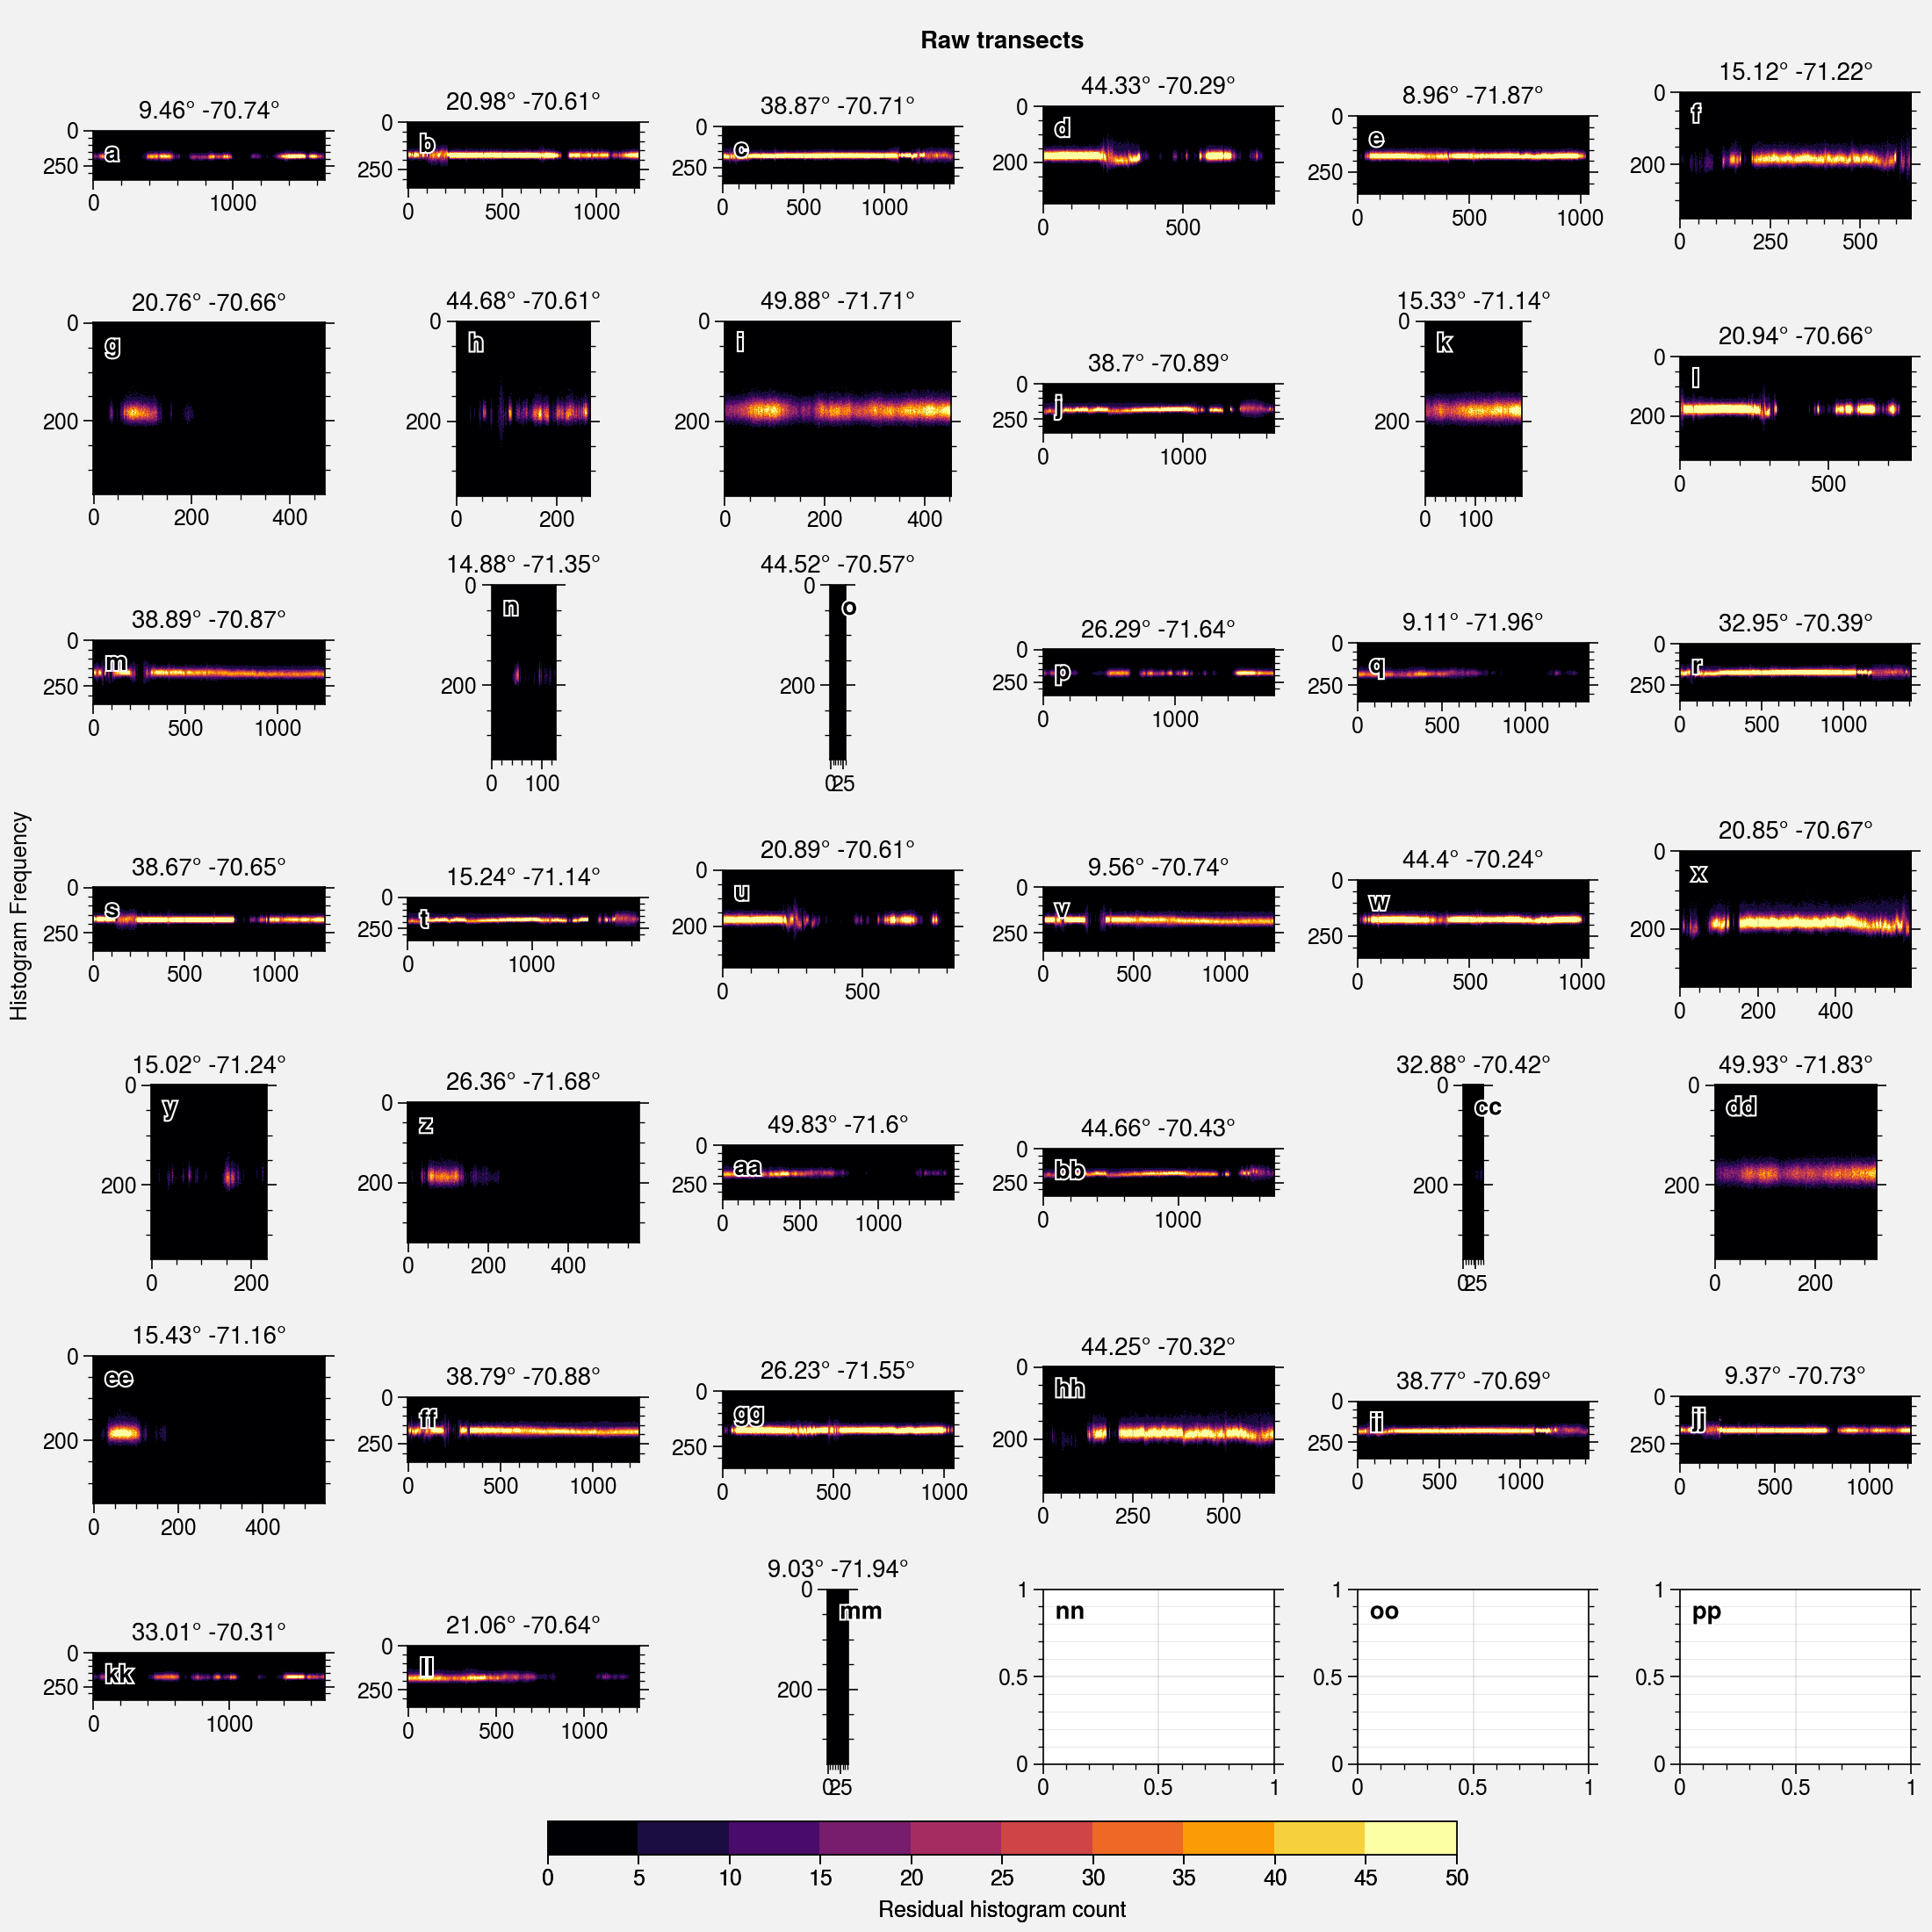

In [75]:
fig_raw, axraw = plot.subplots(ncols=6, nrows=7, share=1, width=11, height=11)
fig_raw.suptitle("Raw transects")
axraw.format(
        abc=True, abcloc='ul',
        ygridminor=True,
        ytickloc='both', yticklabelloc='left'
)

h = axraw[0].imshow(np.transpose(data_array[0]),vmin=0,vmax=50,cmap='inferno')

# Residual histograms
for ax, data, lon, lat in zip(axraw,data_array, lon_files, lat_files):
    ax.imshow(np.transpose(data),vmin=0,vmax=50,cmap='inferno')
    ax.set_ylabel('Histogram Frequency')
    ax.format(title=str(lon) + "° " + str(lat) + "°")
    
fig_raw.colorbar(h, length=0.5, label='Residual histogram count', loc='b', locator=5)

plt.show()

<h2> Plotting track on map</a>

First load the `lon_mean` and `lat_mean` variables.

In [76]:
lon_means, lat_means = [],[]
for lon in lons:
    # We fetch the file name from lon in order to make sure we process the same lat
    lat = lon[:-17] + "lat" + lon[-14:]
    lon_means.append(np.load(os.path.join(path_lon,lon)))
    lat_means.append(np.load(os.path.join(path_lat,lat)))
lon_means = np.asarray(lon_means)
lat_means = np.asarray(lat_means)

In [77]:
spatial_extent_ps = [spatial_extent[0], spatial_extent[2], spatial_extent[1], spatial_extent[3]]

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=6
ticks=np.arange(vmin,vmax+1,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent(spatial_extent_ps, ccrs.PlateCarree())
for lon_mean, lat_mean in zip(lon_means, lat_means):
    plt.plot(lon_mean,lat_mean,transform=ccrs.PlateCarree(), c=np.random.randint(1))
plt.show()

ValueError: Invalid RGBA argument: 0

<Figure size 720x720 with 1 Axes>

Plot comparing mean_lon and mean_lon from histrograms with beam lat and lon.
Firt we load the parameters:

In [12]:
h_lon = np.load(os.path.join(data_dir,'processed_ATL06_20200330121520_00600712_003_01_h_lon_gt1r.npy'))
h_lat = np.load(os.path.join(data_dir,'processed_ATL06_20200330121520_00600712_003_01_h_lat_gt1r.npy'))

In [13]:
"""
plt.figure()
plt.plot(h_lon,h_lat,'ob' )
plt.plot(lon_mean, lat_mean,'.r')
plt.show()
"""

"\nplt.figure()\nplt.plot(h_lon,h_lat,'ob' )\nplt.plot(lon_mean, lat_mean,'.r')\nplt.show()\n"

<h2>Unsupervised learning of ATL06 residual histograms</h2>

In [16]:
from sklearn.cluster import KMeans,AffinityPropagation,DBSCAN,OPTICS,MeanShift,AgglomerativeClustering,Birch
from sklearn.preprocessing import StandardScaler

path_clustering = "/home/jovyan/surface_classification/data/Antarctica_clustering"

In [10]:
for data in data_array:
    print(data.shape)

(1656, 350)
(1226, 350)
(1425, 350)
(830, 350)
(1039, 350)
(642, 350)
(472, 350)
(268, 350)
(454, 350)
(1656, 350)
(193, 350)
(779, 350)
(1257, 350)
(128, 350)
(31, 350)
(1756, 350)
(1379, 350)
(1415, 350)
(1275, 350)
(1866, 350)
(826, 350)
(1273, 350)
(1034, 350)
(595, 350)
(231, 350)
(579, 350)
(1487, 350)
(1714, 350)
(41, 350)
(324, 350)
(547, 350)
(1252, 350)
(1042, 350)
(643, 350)
(1423, 350)
(1221, 350)
(1700, 350)
(1315, 350)
(42, 350)


In [11]:
# Concatenate all subregions together
data = np.concatenate((data_array), axis=0)

print(data.shape)

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(data)

(37036, 350)


In [12]:
#-- K MEANS CLUSTERING

print("Training data shape: " + str(X.shape))

# Use int random_state in order to make centroid initialization deterministic
kmeans4 = KMeans(n_clusters=4, random_state=1).fit(X)
#kmeans10 = KMeans(n_clusters=10, random_state=1).fit(X)
#kmeans16 = KMeans(n_clusters=16, random_state=1).fit(X)

Training data shape: (37036, 350)


In [18]:
#-- AFFINITY PROPAGATION CLUSTERING
# This one needs a lot of damping in order to minimize the division into small clusters
# Despite a super high damping, it finds many small cluster at the transitions between areas
#affinity = AffinityPropagation(random_state=1, damping=0.9999999, max_iter=500).fit(X)

In [ ]:
#-- DBSCAN
dbscan = DBSCAN(eps=20, min_samples=2).fit(X)

In [ ]:
#-- OPTICS
# I haven't found a way to tune this one. All parameters seem to be insensitive to our data
#optics = OPTICS(min_samples=2).fit(X)

In [ ]:
#-- MEAN SHIFT
meanshift = MeanShift(bandwidth=20).fit(X)

In [ ]:
#-- AgglomerativeClustering
agg4 = AgglomerativeClustering(n_clusters=4).fit(X)
#agg16 = AgglomerativeClustering(n_clusters=16).fit(X)

In [ ]:
#-- Birch
birch4 = Birch(n_clusters=4).fit(X)
#birch16 = Birch(n_clusters=16).fit(X)

We plot the classified labels

Text(0, 0.5, 'Classification label')

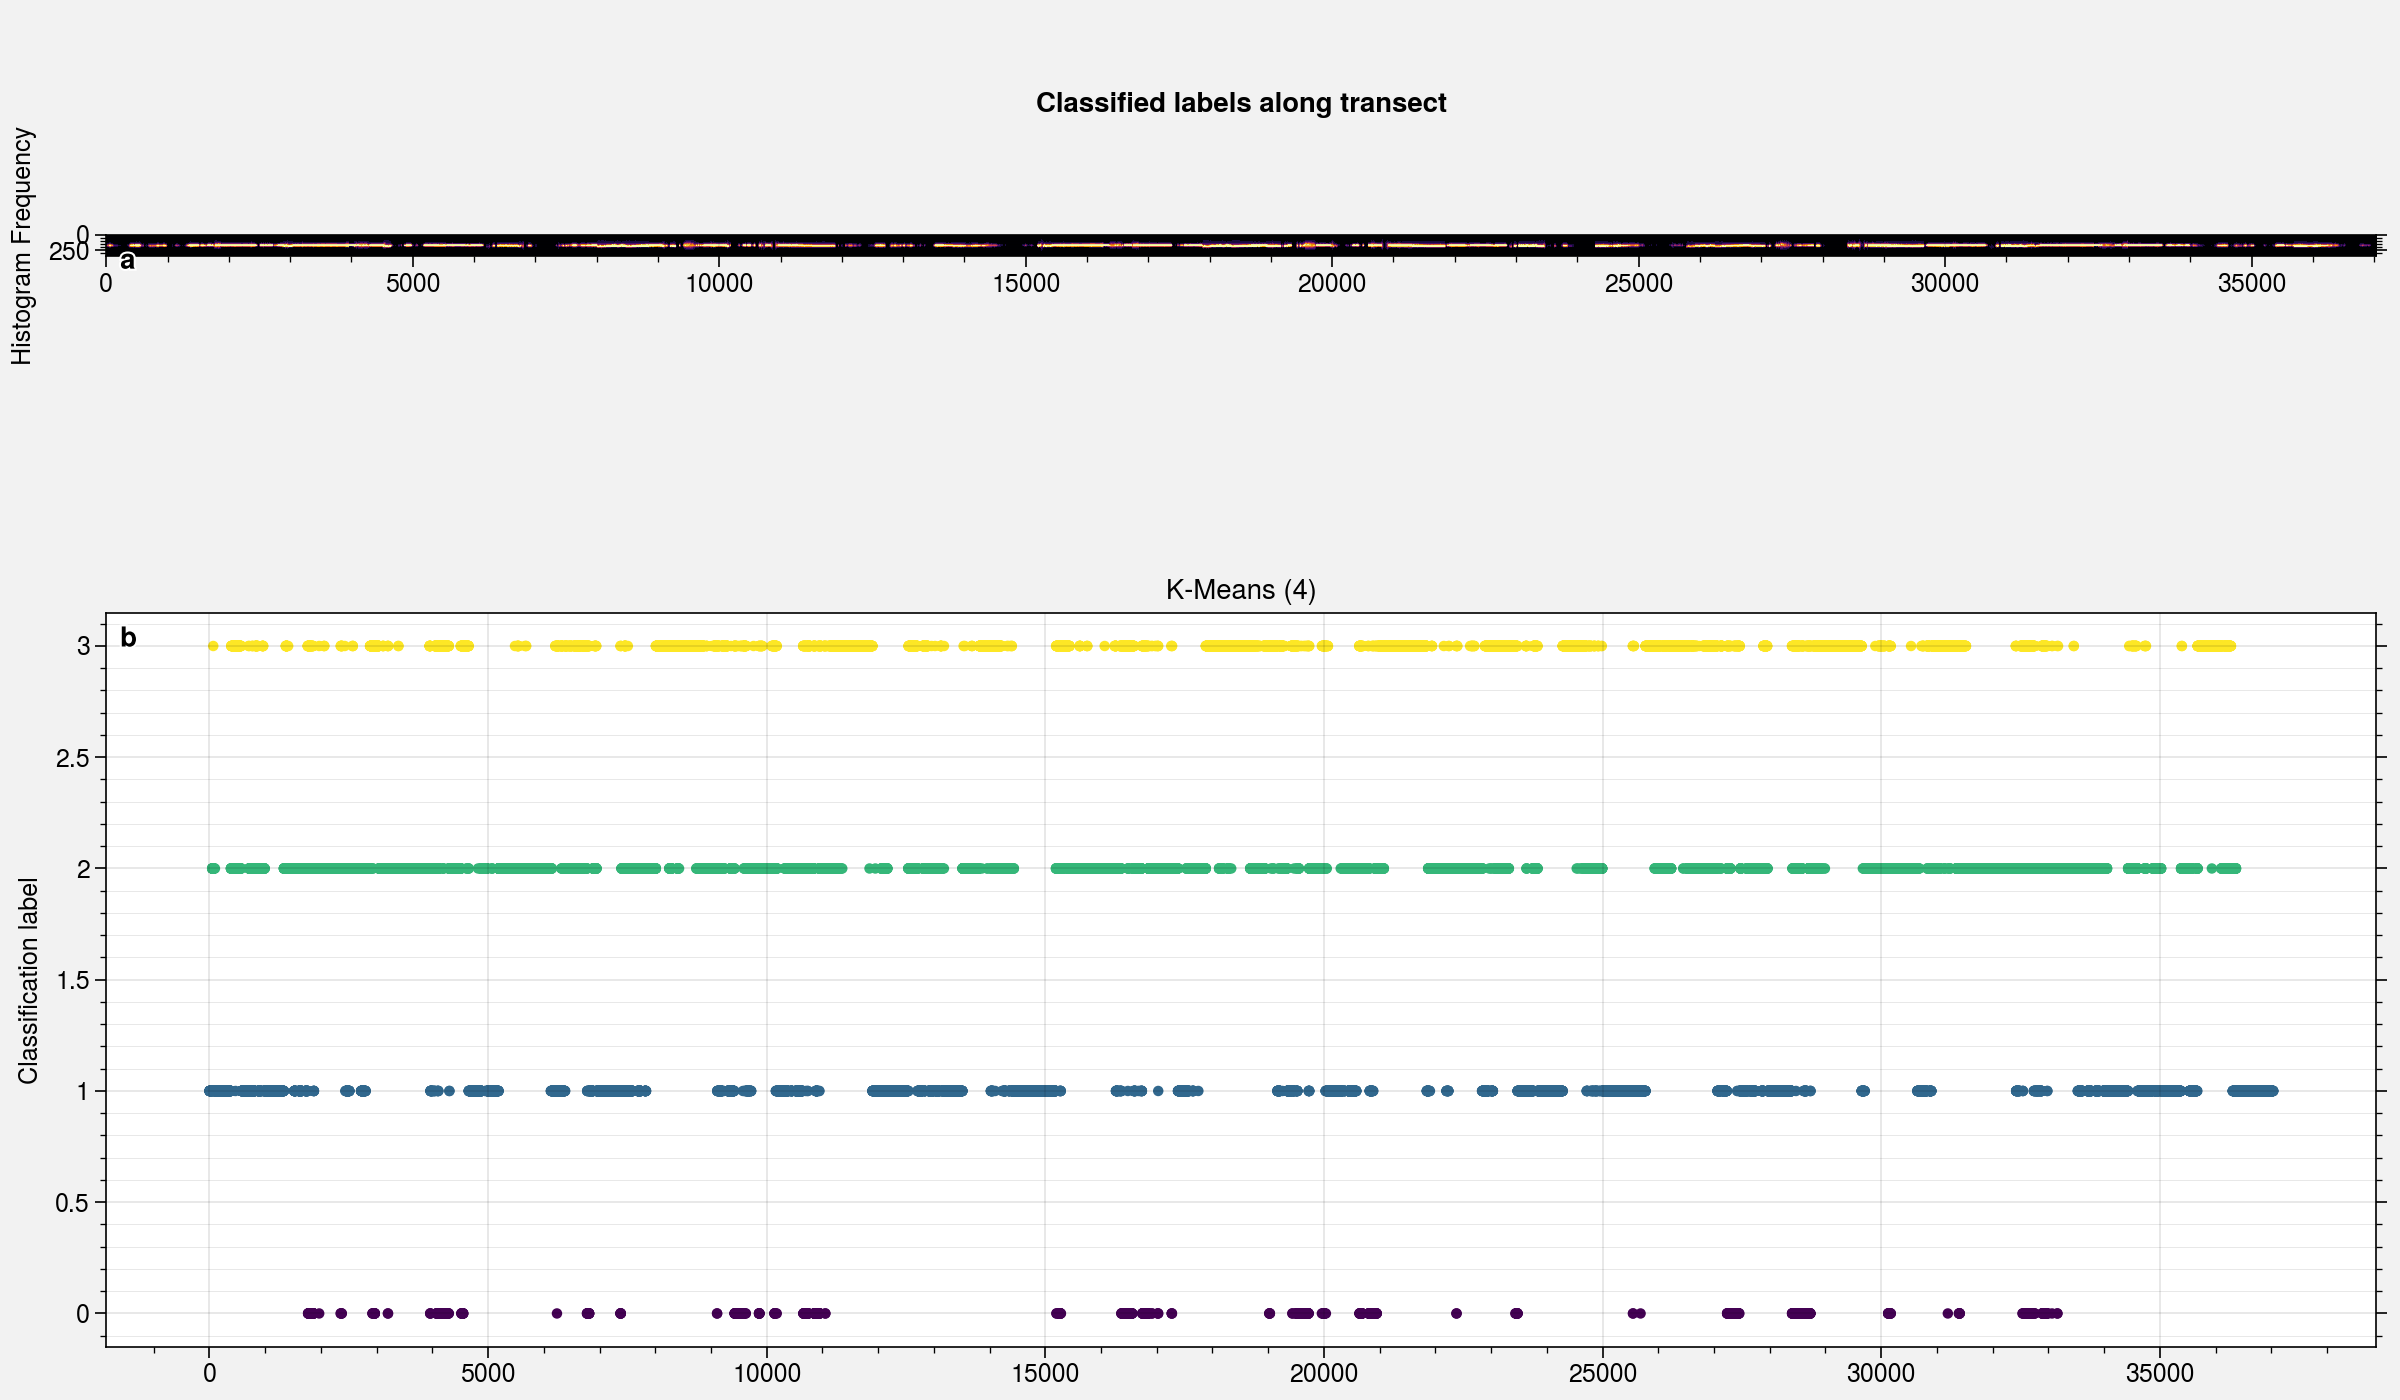

In [14]:
figk, axk = plot.subplots(ncols=1, nrows=2, share=0, width=12, height=7)

figk.suptitle("Classified labels along transect")

axk.format(
        abc=True, abcloc='ul',
        ygridminor=True,
        ytickloc='both', yticklabelloc='left'
)

# Residual histograms
axk[0].imshow(np.transpose(data),vmin=0,vmax=30,cmap='inferno')
axk[0].set_ylabel('Histogram Frequency')


#-- MEAN SHIFT
axk[1].scatter(range(0,data.shape[0]), kmeans4.labels_, c=kmeans4.labels_, s=10, cmap='viridis')
axk[1].set_title('K-Means (4)')
axk[1].set_ylabel('Classification label')


In [ ]:
fig1, ax1 = plot.subplots(ncols=3, nrows=3, share=0, width=9, height=11)

fig1.suptitle("Classified labels along transect")

ax1.format(
        abc=True, abcloc='ul',
        ygridminor=True,
        ytickloc='both', yticklabelloc='left'
)

# Residual histograms
ax1[0,0].imshow(np.transpose(data),vmin=0,vmax=30,cmap='inferno')
ax1[0,0].colorbar(h)
ax1[0,0].set_ylabel('Histogram Frequency')


#-- MEAN SHIFT
ax1[0,1].scatter(range(0,data.shape[0]), meanshift.labels_, c=meanshift.labels_, s=10, cmap='viridis')
ax1[0,1].set_title('Mean Shift')
ax1[0,1].set_ylabel('Classification label')


#-- PLOT DBCAN and OPTICS
ax1[0,2].scatter(range(0,data.shape[0]), dbscan.labels_, c=dbscan.labels_, s=10, cmap='viridis')
ax1[0,2].set_title('DBSCAN')
ax1[0,2].set_ylabel('Classification label')


#----------------------
#-- row with 4 CLUSTERS
#----------------------
#-- k means
ax1[1,0].scatter(range(0,data.shape[0]), kmeans4.labels_, c=kmeans4.labels_, s=10,  cmap='viridis')
ax1[1,0].set_title('K-Means (4)')
ax1[1,0].set_ylabel('Classification label')

#-- AGG
ax1[1,1].scatter(range(0,data.shape[0]), agg4.labels_, c=agg4.labels_, s=10, cmap='viridis')
ax1[1,1].set_title('Agglomerative (4)')
ax1[1,1].set_ylabel('Classification label')

#-- BIRCH
ax1[1,2].scatter(range(0,data.shape[0]), birch4.labels_, c=birch4.labels_, s=10, cmap='viridis')
ax1[1,2].set_title('Birch (4)')
ax1[1,2].set_ylabel('Classification label')


#----------------------
#-- row with 16 CLUSTERS
#----------------------
#-- k means
"""
ax1[2,0].scatter(range(0,data.shape[0]), kmeans16.labels_, c=kmeans16.labels_, s=10, cmap='viridis')
ax1[2,0].set_title('K-Means (16)')
ax1[2,0].set_ylabel('Classification label')


#-- AGG
ax1[2,1].scatter(range(0,data.shape[0]), agg16.labels_, c=agg16.labels_, s=10, cmap='viridis')
ax1[2,1].set_title('Agglomerative (16)')
ax1[2,1].set_ylabel('Classification label')

#-- Birch
ax1[2,2].scatter(range(0,data.shape[0]), birch16.labels_, c=birch16.labels_, s=10, cmap='viridis')
ax1[2,2].set_title('Birch (16)')
ax1[2,2].set_ylabel('Classification label')


#-- PLOT AFFINITY
ax1[2,0].scatter(range(0,data.shape[0]), affinity.labels_, c=affinity.labels_, s=10, cmap='viridis')
ax1[2,0].set_title('Affinity Propagation')
ax1[2,0].set_ylabel('Classification label')

#-- k means (10)
ax1[2,1].scatter(range(0,data.shape[0]), kmeans10.labels_, c=kmeans10.labels_, s=10, cmap='viridis')
ax1[2,1].set_title('K-Means (10)')
ax1[2,1].set_ylabel('Classification label')

#-- optics
ax1[2,2].scatter(range(0,data.shape[0]), optics.labels_, c=optics.labels_, s=10, cmap='viridis')
ax1[2,2].set_title('OPTICS')
ax1[2,2].set_ylabel('Classification label')

"""

#-- label x axes
for i in range(3):
    ax1[3,i].set_xlabel('Segments along track')

if not os.path.exists(path_clustering):
    os.makedirs(path_clustering)
fig1.savefig(os.path.join(path_clustering, 'clustering' + str(spatial_extent) + '.jpeg'))

plt.show()

We display the labels on top of the raster map

In [49]:
data_root='/srv/tutorial-data/land_ice_applications/'
print(os.path.exists(path_clustering))
print(path_clustering)

True
/home/jovyan/surface_classification/data/Antarctica_clustering


In [18]:
! cd ..; [ -d pointCollection ] || git clone https://www.github.com/smithB/pointCollection.git
sys.path.append(os.path.join(os.getcwd(), '..'))
import pointCollection as pc

In [ ]:
try:
    import pointCollection as pc
except Exception:
    !python3 -m pip install --user git+https://github.com/smithb/pointCollection.git
    import pointCollection as pc

In [55]:
#-- Load in mosaic
print("spatial extent: " + str(spatial_extent))
spatial_extent = np.array(spatial_extent)
lat=spatial_extent[[1, 3, 3, 1, 1]]
lon=spatial_extent[[2, 2, 0, 0, 2]]
print(lat)
print(lon)
# project the coordinates to Antarctic polar stereographic
xy=np.array(pyproj.Proj(3031)(lon, lat))
# get the bounds of the projected coordinates 
XR=[np.nanmin(xy[0,:]), np.nanmax(xy[0,:])]
YR=[np.nanmin(xy[1,:]), np.nanmax(xy[1,:])]
MOA=pc.grid.data().from_geotif(os.path.join(data_root, 'MOA','moa_2009_1km.tif'), bounds=[XR, YR])

spatial extent: [  0.  -72.   50.  -68.5]
[-72.  -68.5 -68.5 -72.  -72. ]
[50. 50.  0.  0. 50.]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([5.000000e+01, 1.809050e+06, 1.267825e+06, 2.361825e+06]), 'origin': 'lower'}


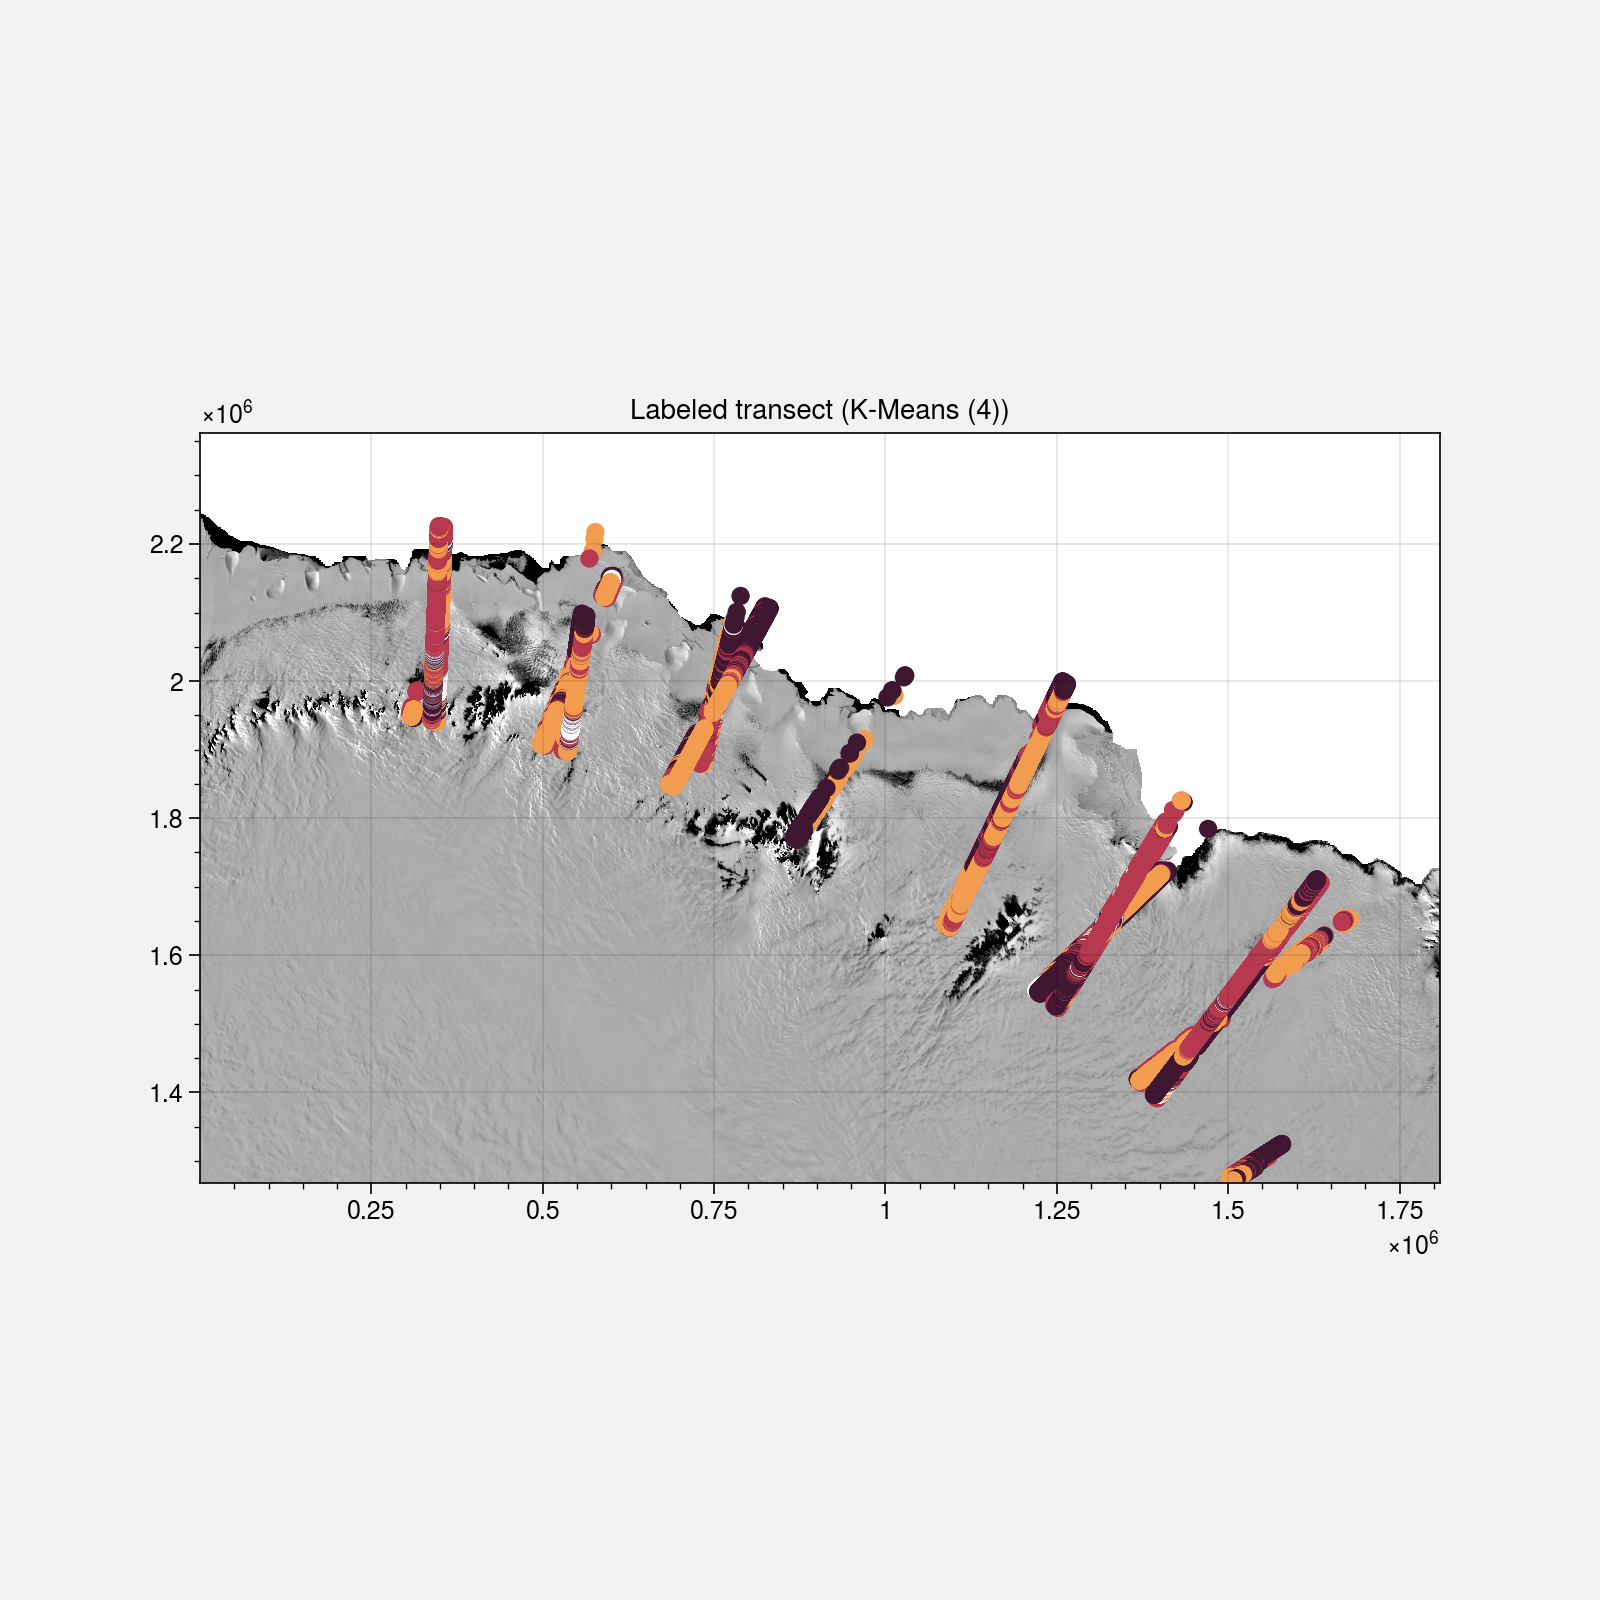

In [85]:
# show the mosaic:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
MOA.show(cmap='gray', clim=[14000, 17000])
#plt.plot(xy[0,:], xy[1,:])
# This still needs to be fixed in order to properly display the transect on the map
i = 0

concat_lons = np.concatenate((lon_means), axis=0)
concat_lats = np.concatenate((lat_means), axis=0)

x_polar, y_polar=np.array(pyproj.Proj(3031)(concat_lons, concat_lats))
plt.scatter(x_polar, y_polar, c=kmeans4.labels_)

"""
for lon_mean, lat_mean in zip(lon_means, lat_means):
    #print("\nlon_mean: " + str(lon_mean.shape))
    #print("lat_mean: " + str(lat_mean.shape))
    labels = kmeans4.labels_[i:i+lon_mean.size]
    #print("i: " + str(i))
    #print("labels: " + str(labels.shape))
    x_polar, y_polar=np.array(pyproj.Proj(3031)(lon_mean, lat_mean))
    plt.scatter(x_polar, y_polar, c=labels, cmap='viridis')
    i = i+lon_mean.size
    #plt.scatter(x_polar, y_polar, c=kmeans4.labels_)
"""
plt.title('Labeled transect (K-Means (4))')
plt.show()

Also plot the Agg results with the same number of clusters (4):

In [ ]:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
ax.stock_img()
plt.plot(xy[0,:], xy[1,:])
# This still needs to be fixed in order to properly display the transect on the map
x_polar, y_polar=np.array(pyproj.Proj(3031)(lon_mean, lat_mean))
plt.scatter(x_polar, y_polar, c=agg4.labels_)
plt.title('Labeled transect (Agg (4))')

In [ ]:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
ax.stock_img()
plt.plot(xy[0,:], xy[1,:])
# This still needs to be fixed in order to properly display the transect on the map
x_polar, y_polar=np.array(pyproj.Proj(3031)(lon_mean, lat_mean))
plt.scatter(x_polar, y_polar, c=birch4.labels_)
plt.title('Labeled transect (Birch (4))')